## Configure PUDL
The `.pudl.yml` configuration file tells PUDL where to look for data. Uncomment the next cell and run it if you're on our 2i2c JupyterHub.

In [ ]:
#!cp ~/shared/shared-pudl.yml ~/.pudl.yml

In [1]:
! pip install plotly

In [2]:
# import the necessary packages
%load_ext autoreload
%autoreload 2

import logging
import os
import sys

import pandas as pd
import sqlalchemy as sa
import pudl

# for visualization: plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import iplot

In [3]:
# setup for python logging
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

## Set your EIA API Key
Some of the routines in this notebook pull data from the EIA API to fill in missing fuel cost values. For them to work, you'll need to provide an API KEY.
* [Obtain an EIA API key here](https://www.eia.gov/opendata/register.php)
* If you put your API key in a shell environment variable named `API_KEY_EIA`, the next cell should work as it is (if you're using the `docker-compose.yml` in the `pudl-tutorial` repository to run our container yourself, it `API_KEY_EIA` will be passed in from your shell to the container automatically).
* You can also uncomment the first line of the next cell, and use it to set the `API_KEY_EIA` environment variable directly.
* If you're running this notebook on your own computer and want to learn more about setting environment variables outside of the notebook [see this blog post](https://www.twilio.com/blog/2017/01/how-to-set-environment-variables.html))

In [4]:
# os.environ["API_KEY_EIA"] = "put your API key here"
assert os.environ.get("API_KEY_EIA") is not None

# Using the PUDL output layer
The PUDL database tables are a clean, [normalized](https://en.wikipedia.org/wiki/Database_normalization) version of US electricity data. Normalized tables are great for databases and storage, but for interactive use, we often want a version of the data that includes plant and utility names and other associated info all in a single dataframe. These are "denormalized" tables. In addition to the referenced names and attributes like latitude and longitude or state, the denormalized tables often contain frequently calculated derived values (like calcuating `total_fuel_cost` from `total_heat_content_mmbtu` and `fuel_cost_per_mmbtu`). The Catalyst team developed a useful tool to access denormalized tables that we call the PUDL output object.

## What does the output layer provide?

Right now the output layer provides access to three different kinds of things:
 * denormalized tables
 * analytical outputs
 * partially integrated PUDL datasets that aren't in the database yet

## Why is the output layer useful?
Some benefits of using the output layer:
 * **Standardized denormalization:** You don't have to manually join the same tables together to get access to common attributes.
 * **Table caching:** many analyses rely on using the same table multiple times. The PUDL output object caches the tables in memory as pandas dataframes so you don't have to read tables from the database over and over again.
 * **Time series aggregation:** Some tables are annual, some monthly, some hourly. When you create a PUDL output object you can tell it to aggregate the data to either monthly or annual resolution for analysis.
 * **Standardized the filling-in of missing data:** There's a ton of missing or incomplete data. If requested, the output objects will use rolling averages and  data from the EIA API try to fill some of that missing data in.

# Instantiating Output Objects
* Grab the `pudl_settings`
* Create a connection to the PUDL Database
* Instantiate a `PudlTabl` object with that connection

In [5]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_settings

{'pudl_in': '/home/jovyan/shared',
 'data_dir': '/home/jovyan/shared/data',
 'settings_dir': '/home/jovyan/shared/settings',
 'pudl_out': '/home/jovyan/shared',
 'sqlite_dir': '/home/jovyan/shared/sqlite',
 'parquet_dir': '/home/jovyan/shared/parquet',
 'datapkg_dir': '/home/jovyan/shared/datapkg',
 'ferc1_db': 'sqlite:////home/jovyan/shared/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/jovyan/shared/sqlite/pudl.sqlite',
 'censusdp1tract_db': 'sqlite:////home/jovyan/shared/sqlite/censusdp1tract.sqlite'}

In [6]:
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pudl_engine

Engine(sqlite:////home/jovyan/shared/sqlite/pudl.sqlite)

In [7]:
# this configuration will return tables without aggregating by a time frequency... we'll explore that more below.
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine=pudl_engine)

## List the output object methods
* There are dozens of different data access methods within the `PudlTabl` object. If you want to see all of them with their docstrings, you can un-comment and run `help(pudl_out)` in the next cell.
* If you type `pudl_out.` and press `Shift` and `Tab` at the same time, you'll see a list of available methods as well.

In [8]:
#help(pudl_out)

This cell will print out a simple list of all the available public methods inside the `pudl_out` object

In [8]:
# this is the master list of all of the methods in the pudl_out object
# they all return a table cooresponding to their name
methods_pudl_out = [
    method_name for method_name in dir(pudl_out)
    if callable(getattr(pudl_out, method_name))    # if it is a method
    and '__' not in method_name                    # remove the internal methods
]
methods_pudl_out

['adjacency_ba_ferc714',
 'advanced_metering_infrastructure_eia861',
 'balancing_authority_assn_eia861',
 'balancing_authority_eia861',
 'bf_eia923',
 'bga_eia860',
 'capacity_factor',
 'demand_forecast_pa_ferc714',
 'demand_hourly_pa_ferc714',
 'demand_monthly_ba_ferc714',
 'demand_response_eia861',
 'demand_side_management_eia861',
 'description_pa_ferc714',
 'distributed_generation_eia861',
 'distribution_systems_eia861',
 'dynamic_pricing_eia861',
 'energy_efficiency_eia861',
 'etl_eia861',
 'etl_ferc714',
 'fbp_ferc1',
 'frc_eia923',
 'fuel_cost',
 'fuel_ferc1',
 'gen_allocated_eia923',
 'gen_eia923',
 'gen_original_eia923',
 'gen_plants_ba_ferc714',
 'gens_eia860',
 'gf_eia923',
 'green_pricing_eia861',
 'hr_by_gen',
 'hr_by_unit',
 'id_certification_ferc714',
 'interchange_ba_ferc714',
 'lambda_description_ferc714',
 'lambda_hourly_ba_ferc714',
 'mcoe',
 'mergers_eia861',
 'net_energy_load_ba_ferc714',
 'net_metering_eia861',
 'non_net_metering_eia861',
 'operational_data_eia861

## Basic Functionality

### Read a denormalized table
* Each of output object methods will return a Pandas Dataframe.
* Most of them correspond to a single database table, and will select all the data in that table, and automatically join it with some other useful information.
* Many of the access methods use an abbreviated name for the database table. E.g. the following reads all the data out of the `generators_eia860` table.

In [9]:
# %%time
# gens_eia860 = pudl_out.gens_eia860().info()

### Automatic dataframe caching
The `generators_eia860` table is quite long, and the above cell probably took several seconds to read 270,000 records each with 100 columns, creating an 800MB Dataframe. If you run the same output routine again, it will complete almost instantly because that dataframe is already stored inside `pudl_out`. This is memory intensive, but can save time in calculations that need to use the same tables several times.

In [10]:
# %%time
# gens_again_eia860 = pudl_out.gens_eia860()

## Exploring `pudl_out` Arguments
Below, we'll explore the main arguments that are used to customize the PUDL output object. You can mix and match these options.

By default, the output object will read data from all available years, do no time aggregation, and not attempt to fill in missing values.

In [11]:
# here are the default arguments for the pudl_out object
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine, # we always need a pudl_engine
    freq=None,               # Desired time grouping to aggregate PUDL tables to.
    start_date=None,         # Beginning date for data to pull from the PUDL DB.
    end_date=None,           # End date for data to pull from the PUDL DB.
    fill_fuel_cost=False,    # Whether to fill in missing fuel costs with EIA monthly state-level averages.
    roll_fuel_cost=False,    # Whether to fill in monthly missing fuel costs with a 12-month rolling average.
)

### Time series aggregation
The PUDL output object can aggregate data on a monthly or annual basis, if you set the `freq` argument to `AS` (annual starting at the beginning of the calendar year) or `MS` (monthly starting at the beginning of the month) or [other equivalent frequency abbreviations](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases).

**NOTE:** Not all columns can be aggregated, so you may lose access to some kinds of information in aggregated outputs. If you need to retain information that gets lost in the default aggregation / groupby process, you may need to pull the unaggregated data and do your own aggregation.

In [12]:
pudl_out_as = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine, # we always need a pudl_engine
    freq='MS',               # Aggregate tables annually
)

In [13]:
#pudl_out_as.fuel_cost().head()

Questions for further development and exploration:
- are energy consumers (retail & industrial) adjusting consumption based on variable energy price? **(need demand, energy pricing (demand_hourly_pa_ferc714, dynamic_pricing_eia861, fuel_cost, etl_ferc714, net_energy_load_ba_ferc714) for this)**
- do weather features such as temperature, humidity, rainfall etc correlate to energy demand? **(need weather data from Meteomatics for this)**
    - [Some inspiration in this notebook](https://www.kaggle.com/dimitriosroussis/eda-cleaning-visualizations-ongoing-project/notebook)
- is there a relationship between holidays, and vacation periods and consumption?
- does the data suggest the influence of major industrial consumers is shaping demand? **(need to find industry breakdown in PUDL)
    - pulling data on indsutry breakdown and industrial vs retail consumers could help here (if available)
    
In the current version the notebook contains
**1. Inital descrption and Distribution**  
**2. Yearly Breakdowns**   
    1. yearly consumption profiles
    2. mean load per hour
    3. load curves 2006-2020
    4. box plot load and consumption
**3. Monthly Breakdowns**  
    1. monthly average consumption profiles
    2. monthly mean load per hour
    3. average monthly load curve
    4. box plot load and consumption
**4. Interweek breakdowns**  
    1. Interweek average load by hour
    2. daily load average box plots

In [14]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

Shape of entire FERC 714 demand data set:

In [15]:
#pudl_out_as.demand_hourly_pa_ferc714().shape

Create dataframe of FERC 714 demand data:

In [16]:
pudl_demand_hourly_pa_ferc714 = pudl_out_as.demand_hourly_pa_ferc714()

Running the interim FERC 714 ETL process!
Extracting respondent_id_ferc714 from CSV into pandas DataFrame.


/srv/conda/envs/notebook/lib/python3.9/site-packages/pudl/extract/ferc714.py:59: UserWarning:

Integration of FERC 714 into PUDL is still experimental and incomplete.
The data has not yet been validated, and the structure may change.



Extracting id_certification_ferc714 from CSV into pandas DataFrame.
Extracting gen_plants_ba_ferc714 from CSV into pandas DataFrame.
Extracting demand_monthly_ba_ferc714 from CSV into pandas DataFrame.
Extracting net_energy_load_ba_ferc714 from CSV into pandas DataFrame.
Extracting adjacency_ba_ferc714 from CSV into pandas DataFrame.
Extracting interchange_ba_ferc714 from CSV into pandas DataFrame.
Extracting lambda_hourly_ba_ferc714 from CSV into pandas DataFrame.
Extracting lambda_description_ferc714 from CSV into pandas DataFrame.
Extracting description_pa_ferc714 from CSV into pandas DataFrame.
Extracting demand_forecast_pa_ferc714 from CSV into pandas DataFrame.
Extracting demand_hourly_pa_ferc714 from CSV into pandas DataFrame.
Transforming respondent_id_ferc714.
Transforming id_certification_ferc714.
Transforming gen_plants_ba_ferc714.
Transforming demand_monthly_ba_ferc714.
Transforming net_energy_load_ba_ferc714.
Transforming adjacency_ba_ferc714.
Transforming interchange_ba_f

Subset data to Florida-only balancing authorities:

In [17]:
list_of_fl_ids = [140,169,170,171,172,191,225,234,242,248,262,298,325,326,327]
florida_demand_hourly_pa_ferc714 = pudl_demand_hourly_pa_ferc714.loc[pudl_demand_hourly_pa_ferc714.respondent_id_ferc714.isin(list_of_fl_ids)]

Get shape of Florida balancing authorities dataframe:

In [18]:
florida_demand_hourly_pa_ferc714.shape

(1227120, 5)

In [19]:
florida_demand_hourly_pa_ferc714.head()

respondent_id_ferc714 report_date        utc_datetime          timezone  \
2920                    169  2006-01-01 2006-01-01 05:00:00  America/New_York   
2921                    169  2006-01-01 2006-01-02 05:00:00  America/New_York   
2922                    169  2006-01-01 2006-01-03 05:00:00  America/New_York   
2923                    169  2006-01-01 2006-01-04 05:00:00  America/New_York   
2924                    169  2006-01-01 2006-01-05 05:00:00  America/New_York   

      demand_mwh  
2920       549.0  
2921       519.0  
2922       540.0  
2923       518.0  
2924       522.0

In [20]:
florida_demand_hourly_pa_sorted = florida_demand_hourly_pa_ferc714.sort_values(by = 'utc_datetime')

In [21]:
df_long = florida_demand_hourly_pa_sorted.copy()

In [ ]:
florida_demand_hourly_pa_sorted

### Exploratory data analysis

Monthly average power demand by Florida PA/BA.

In [22]:
import calendar
monthly_df = df_long.groupby([df_long.utc_datetime.dt.year, df_long.utc_datetime.dt.month,df_long.respondent_id_ferc714])['demand_mwh'].mean()
monthly_df.index = monthly_df.index.set_names(['year', 'month','response_id'])
#print(monthly_df.head())
monthly_df = monthly_df.reset_index()
monthly_df['month'] = monthly_df['month'].apply(lambda x: calendar.month_abbr[x])

In [23]:
monthly_df.head()

year month  response_id    demand_mwh
0  2006   Jan          140    289.635995
1  2006   Jan          169    703.602165
2  2006   Jan          171  10824.393775
3  2006   Jan          172    205.665765
4  2006   Jan          191    301.714479

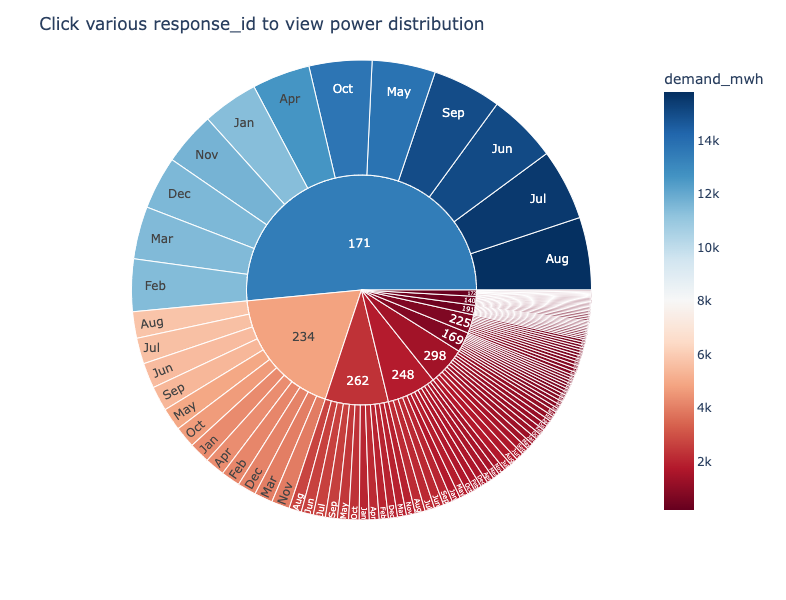

In [24]:
import plotly.express as px
fig = px.sunburst(monthly_df, path=['response_id','month'], values='demand_mwh',
                  color='demand_mwh',
                  color_continuous_scale='RdBu')
fig.update_layout(title='Click various response_id to view power distribution')
fig.update_layout( width=800,height=600)
fig.show()

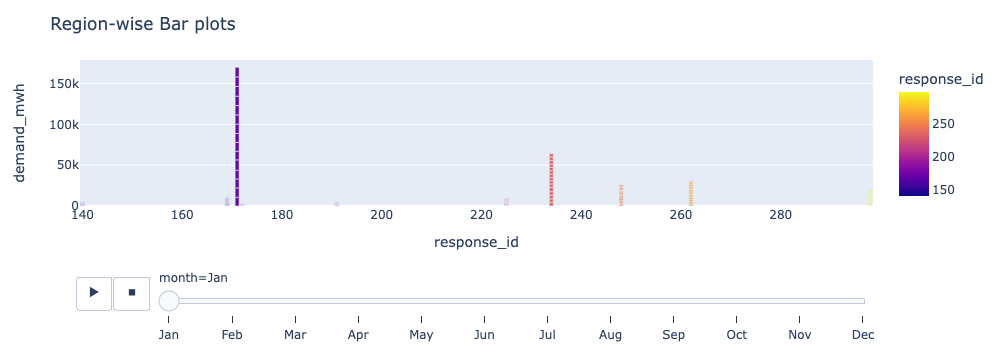

In [24]:
fig = px.bar(monthly_df, x="response_id", y="demand_mwh",color='response_id',animation_frame = 'month')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_layout(title='Region-wise Bar plots')
fig.show()

Look at just Tampa's data (262):

In [25]:
tampa_demand_hourly = florida_demand_hourly_pa_ferc714.loc[florida_demand_hourly_pa_ferc714.respondent_id_ferc714==262]

In [26]:
tampa_demand_hourly.shape

(122712, 5)

Sort by utc date. This is an hourly demand data set.

In [ ]:
tampa_demand_hourly_sorted = tampa_demand_hourly.sort_values(by = 'utc_datetime')
tampa_demand_hourly_sorted.head(10)

respondent_id_ferc714 report_date        utc_datetime  \
34675                      262  2006-01-01 2006-01-01 05:00:00   
654818                     262  2006-01-01 2006-01-01 06:00:00   
1274961                    262  2006-01-01 2006-01-01 07:00:00   
1895104                    262  2006-01-01 2006-01-01 08:00:00   
2515247                    262  2006-01-01 2006-01-01 09:00:00   
3135390                    262  2006-01-01 2006-01-01 10:00:00   
3755533                    262  2006-01-01 2006-01-01 11:00:00   
4375676                    262  2006-01-01 2006-01-01 12:00:00   
4995819                    262  2006-01-01 2006-01-01 13:00:00   
5615962                    262  2006-01-01 2006-01-01 14:00:00   

                 timezone  demand_mwh  
34675    America/New_York      1456.0  
654818   America/New_York      1400.0  
1274961  America/New_York      1312.0  
1895104  America/New_York      1262.0  
2515247  America/New_York      1251.0  
3135390  America/New_York      1268.0  
3755533  America/New_York      1294.0  
4375676  America/New_York      1356.0  
4995819  America/New_York      1459.0  
5615962  America/New_York      1583.0

Get min and max time ranges of Florida Municipal Power's hourly demand set.

In [ ]:
tampa_demand_hourly_sorted.utc_datetime.describe()

/tmp/ipykernel_63/1780828752.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  122712
unique                 122712
top       2013-06-07 22:00:00
freq                        1
first     2006-01-01 05:00:00
last      2020-01-01 04:00:00
Name: utc_datetime, dtype: object

Aggregate data by day. (Come back to this)

Florida Municipal Power hourly demand for 2017-2019 number of rows.

In [30]:
tampa_demand_hourly_2014_2019 = tampa_demand_hourly_sorted.loc[tampa_demand_hourly_sorted.report_date > '2013-12-31']

In [32]:
tampa_demand_hourly_2014_2019.shape

(52584, 5)

In [33]:
tampa_demand_hourly_2014_2019.isna().sum()

respondent_id_ferc714    0
report_date              0
utc_datetime             0
timezone                 0
demand_mwh               0
dtype: int64

In [34]:
tampa_demand_hourly_2014_2019.describe(include="all")

/tmp/ipykernel_63/733083720.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/tmp/ipykernel_63/733083720.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



respondent_id_ferc714          report_date         utc_datetime  \
count                 52584.0                52584                52584   
unique                    NaN                    6                52584   
top                       NaN  2016-01-01 00:00:00  2015-09-19 22:00:00   
freq                      NaN                 8784                    1   
first                     NaN  2014-01-01 00:00:00  2014-01-01 05:00:00   
last                      NaN  2019-01-01 00:00:00  2020-01-01 04:00:00   
mean                    262.0                  NaN                  NaN   
std                       0.0                  NaN                  NaN   
min                     262.0                  NaN                  NaN   
25%                     262.0                  NaN                  NaN   
50%                     262.0                  NaN                  NaN   
75%                     262.0                  NaN                  NaN   
max                     262.0                  NaN                  NaN   

                timezone    demand_mwh  
count              52584  52584.000000  
unique                 1           NaN  
top     America/New_York           NaN  
freq               52584           NaN  
first                NaN           NaN  
last                 NaN           NaN  
mean                 NaN   2306.126597  
std                  NaN    615.743458  
min                  NaN    840.000000  
25%                  NaN   1868.000000  
50%                  NaN   2169.000000  
75%                  NaN   2706.000000  
max                  NaN   4298.000000

In [35]:
tampa_demand_hourly_2014_2019.to_csv('tampa_electric_co_demand_hourly.csv')

Copy dataframe for plotting:

In [36]:
df = tampa_demand_hourly_2014_2019.copy()

In [37]:
# Convention for import of the pyplot interface
import matplotlib.pyplot as plt

# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline

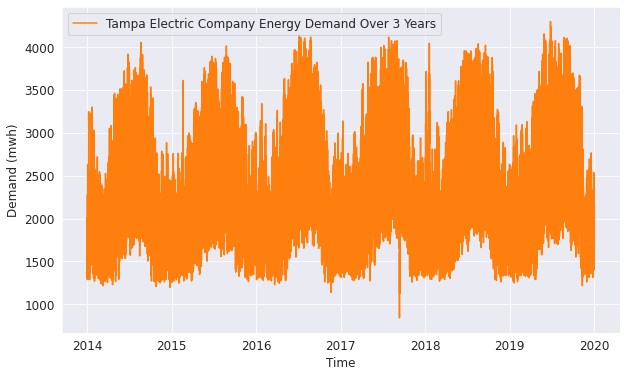

In [38]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(df.utc_datetime, df.demand_mwh, color='tab:orange', label='Tampa Electric Company Energy Demand Over 3 Years')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Demand (mwh)')
ax.grid(True)
ax.legend(loc='upper left');

### Time series analysis

In [ ]:
print(display(pudl_out_gen_eia923.head()))
print(pudl_out_gen_eia923.shape)

In [37]:
florida_pudl_gen_eia923 = pudl_out_as.gens_eia860().loc[pudl_out_as.gens_eia860().utility_name_eia.str.contains('Florida')]

In [38]:
print(display(florida_pudl_gen_eia923.head()))
print(florida_pudl_gen_eia923.shape)

report_date  plant_id_eia  plant_id_pudl  plant_name_eia  \
28260  2009-01-01           609             92  Cape Canaveral   
28261  2009-02-01           609             92  Cape Canaveral   
28262  2009-03-01           609             92  Cape Canaveral   
28263  2009-04-01           609             92  Cape Canaveral   
28264  2009-05-01           609             92  Cape Canaveral   

       utility_id_eia  utility_id_pudl          utility_name_eia generator_id  \
28260            6452              121  Florida Power & Light Co            1   
28261            6452              121  Florida Power & Light Co            1   
28262            6452              121  Florida Power & Light Co            1   
28263            6452              121  Florida Power & Light Co            1   
28264            6452              121  Florida Power & Light Co            1   

       net_generation_mwh  
28260             31825.0  
28261             58170.0  
28262             40791.0  
28263             53787.0  
28264            102503.0

None
(10944, 9)


In [39]:
florida_pudl_gen_eia923.report_date.describe()

<ipython-input-39-652097fc127a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  florida_pudl_gen_eia923.report_date.describe()


count                   10944
unique                    132
top       2019-12-01 00:00:00
freq                      119
first     2009-01-01 00:00:00
last      2019-12-01 00:00:00
Name: report_date, dtype: object

In [40]:
florida_pudl_gen_eia923.to_csv('florida_pudl_gen_eia923.csv')

In [13]:
pudl_out_ms = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine, # we always need a pudl_engine
    freq='MS',               # Aggregate tables monthly
)

In [14]:
pudl_out_ms.gen_eia923().head()

report_date  plant_id_eia  plant_id_pudl plant_name_eia  utility_id_eia  \
0  2009-01-01             3             32          Barry             195   
1  2009-02-01             3             32          Barry             195   
2  2009-03-01             3             32          Barry             195   
3  2009-04-01             3             32          Barry             195   
4  2009-05-01             3             32          Barry             195   

   utility_id_pudl  utility_name_eia generator_id  net_generation_mwh  
0               18  Alabama Power Co            1             39699.0  
1               18  Alabama Power Co            1              5594.0  
2               18  Alabama Power Co            1             13015.0  
3               18  Alabama Power Co            1             15858.0  
4               18  Alabama Power Co            1             68232.0

### Filling in Missing Fuel Costs
 * The original EIA data is often incomplete.
 * Many utilities withold information about their fuel costs.
 * We have a couple of ways of estimating missing values, if you need complete data.

The ouput object created in the next cell will attempt to use all of these methods to fill in missing data.
To fill in missing fuel costs, we can pull monthly state-level average fuel costs from EIA, and we can use rolling averages to fill in short gaps in the data.
* Set `fill_fuel_cost=True` when creating an output object to pull average monthly fuel costs from the EIA API.
* Set `roll_fuel_cost=True` when creating an output object to use a 12-month rolling average based on available data to fill in gaps.
* These options can be used together to fill in as many gaps as possible.
* **NOTE:** You need to have set the `API_KEY_EIA` environment variable to a valid EIA API key for this to work. See instructions at the top of this notebook.

In [15]:
pudl_out_fill = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine, # we always need a pudl_engine
    freq='MS',               # Aggregate tables monthly
    fill_fuel_cost=True,     # Fill in missing fuel cost records with state-level averages from EIA's API
    roll_fuel_cost=True,     # Fill in missing fuel cost records with a 12-month rolling average.
)

In [16]:
%%time
pudl_out_fill.frc_eia923().head()

filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages
CPU times: user 1min 57s, sys: 2.69 s, total: 2min
Wall time: 2min 9s


report_date  plant_id_eia  plant_id_pudl plant_name_eia  utility_id_eia  \
0  2009-01-01             3             32          Barry             195   
1  2009-02-01             3             32          Barry             195   
2  2009-03-01             3             32          Barry             195   
3  2009-04-01             3             32          Barry             195   
4  2009-05-01             3             32          Barry             195   

   utility_id_pudl  utility_name_eia  ash_content_pct  chlorine_content_ppm  \
0               18  Alabama Power Co        10.013475                   NaN   
1               18  Alabama Power Co         9.026785                   NaN   
2               18  Alabama Power Co         6.449671                   NaN   
3               18  Alabama Power Co         7.520152                   NaN   
4               18  Alabama Power Co         6.669016                   NaN   

   fuel_cost_from_eiaapi  fuel_cost_per_mmbtu  fuel_qty_units  \
0                  False             4.526190        381438.0   
1                  False             4.096987        410147.0   
2                  False             3.709062        376787.0   
3                  False             3.897879        105322.0   
4                  False             3.672290        367333.0   

  fuel_type_code_pudl  heat_content_mmbtu_per_unit  mercury_content_ppm  \
0                coal                    23.334763                  NaN   
1                coal                    23.056621                  NaN   
2                coal                    22.876760                  NaN   
3                coal                    23.160458                  NaN   
4                coal                    22.899997                  NaN   

   moisture_content_pct  sulfur_content_pct  total_fuel_cost  \
0                   NaN            0.938976     4.028655e+07   
1                   NaN            0.822421     3.874359e+07   
2                   NaN            0.487466     3.197087e+07   
3                   NaN            0.523833     9.508120e+06   
4                   NaN            0.621304     3.089103e+07   

   total_heat_content_mmbtu  
0               8900765.245  
1               9456604.085  
2               8619665.590  
3               2439305.763  
4               8411924.736

Looking at the filled vs. unfilled monthly data in the Fuel Receipts and Costs data from EIA 923, we can see that there are about 190k possible monthly records. Unfilled, we have fuel costs for about 107k of them. With the state level monthly fuel costs and rolling averages, we can get that up to about 116k records. An improvement, but it's not great. Unfortunately this data simply isn't reported publicly.

In [17]:
pudl_out_ms.frc_eia923()[["plant_id_eia", "report_date", "fuel_cost_per_mmbtu"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190115 entries, 0 to 190114
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   plant_id_eia         190115 non-null  Int64         
 1   report_date          190115 non-null  datetime64[ns]
 2   fuel_cost_per_mmbtu  106695 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(1)
memory usage: 6.0 MB


In [18]:
pudl_out_fill.frc_eia923()[["plant_id_eia", "report_date", "fuel_cost_per_mmbtu"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190115 entries, 0 to 190114
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   plant_id_eia         190115 non-null  Int64         
 1   report_date          190115 non-null  datetime64[ns]
 2   fuel_cost_per_mmbtu  115786 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(1)
memory usage: 6.0 MB


## Free Memory
Because this JupyterHub has limited memory, we need to delete the cached dataframes when we're done with them.

In [19]:
del pudl_out
del pudl_out_ms
del pudl_out_as
del pudl_out_fill

# Denormalized Output Tables
* Below, we'll extract and show a sample of many of the available denormalized PUDL output tables.
* If you'd like to see more than 5 sample rows, feel free to change `n_samples` below.
* Rather than assigning the results of these functions to a local variable in the notebook, we're showing samples from the cached dataframes to conserve memory, as this JupyterHub has limited RAM available at the moment.

In [28]:
n_samples = 5
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine=pudl_engine)

## EIA Forms 860 & 923

In [21]:
# here are all of the EIA tables
tables_eia = [
    t for t in methods_pudl_out 
    if '_eia' in t 
    and '_eia861' not in t       # avoid the EIA 861 tables for now bc it is preliminary
]
tables_eia

['bf_eia923',
 'bga_eia860',
 'frc_eia923',
 'gen_allocated_eia923',
 'gen_eia923',
 'gen_original_eia923',
 'gens_eia860',
 'gf_eia923',
 'own_eia860',
 'plants_eia860',
 'pu_eia860',
 'utils_eia860']

### EIA Plant Utility Associations
This is mostly a helper function, used for adding plant and utility names and IDs into other output tables.

In [24]:
%%time
pudl_out.pu_eia860().sample(n_samples)

CPU times: user 7.93 s, sys: 16 ms, total: 7.95 s
Wall time: 8.01 s


report_date  plant_id_eia             plant_name_eia  plant_id_pudl  \
19404   2006-01-01          2051                 Delta (MS)            153   
105068  2013-01-01         57419          RPI Fuel Cell LLC           5726   
120272  2013-01-01         59227         Optimum Wind 3 LLC          10655   
31477   2020-01-01          3611                O W Sommers           2385   
83404   2019-01-01         55557  Wilmington Hydrogen Plant           4592   

        utility_id_eia               utility_name_eia  utility_id_pudl  
19404            12685        Entergy Mississippi LLC              109  
105068           56748              RP1 Fuel Cell LLC             3055  
120272           59025             Optimum Wind 3 LLC             5143  
31477            16604  San Antonio Public Service Bd             1178  
83404              991   Air Products & Chemicals Inc              427

### EIA 860 Boiler Generator Associations
* **NOTE:** We have filled in many more boiler-generator associations based on additional information. The `bga_source` column indicates where the association came from.

In [25]:
%%time
pudl_out.bga_eia860().sample(n_samples)

CPU times: user 707 ms, sys: 8.34 ms, total: 716 ms
Wall time: 731 ms


plant_id_eia report_date generator_id boiler_id unit_id_eia  \
37586         10521  2019-01-01         GEN2      GEN2         CC1   
39186         10606  2018-01-01         GEN5        9A        None   
57122         50561  2018-01-01         STG2      0002         CC1   
91098         55501  2014-01-01         STG2      CTG3        STG2   
70985         54349  2018-01-01          STM       GTA        STG1   

       unit_id_pudl   bga_source  
37586             1  string_assn  
39186             1   eia860_org  
57122             1   eia860_org  
91098             2   eia860_org  
70985             1   eia860_org

### EIA 860 Plants

In [26]:
%%time
pudl_out.plants_eia860().sample(n_samples)

CPU times: user 3.87 s, sys: 32 ms, total: 3.9 s
Wall time: 3.92 s


plant_id_eia                plant_name_eia  \
88733          56002                       Minwind   
5106             437                Edward C Hyatt   
74546          54713    Alliant SBD 8603 Donnelley   
138660         63220  USS Water City Solar LLC CSG   
118906         58925         Sangamon Wind One LLC   

       balancing_authority_code_eia  \
88733                          MISO   
5106                           CISO   
74546                          MISO   
138660                         MISO   
118906                         MISO   

                             balancing_authority_name_eia        city  \
88733   Midcontinent Independent Transmission System O...     Luverne   
5106               California Independent System Operator    Oroville   
74546   Midcontinent Independent Transmission System O...      Nevada   
138660  Midcontinent Independent Transmission System O...  Waterville   
118906  Midcontinent Independent Transmission System O...         TBD   

          county ferc_cogen_status ferc_exempt_wholesale_generator  \
88733       Rock             False                           False   
5106       Butte             False                           False   
74546      Story             False                           False   
138660  Le Sueur             False                           False   
118906  Sangamon             False                           False   

       ferc_small_power_producer  grid_voltage_kv  ...  pipeline_notes  \
88733                      False             24.5  ...            None   
5106                       False            230.0  ...            None   
74546                      False              NaN  ...            None   
138660                      True             34.5  ...            None   
118906                     False             69.0  ...            None   

        regulatory_status_code transmission_distribution_owner_id  \
88733                       NR                              56088   
5106                        RE                              14328   
74546                       NR                               None   
138660                      NR                              13781   
118906                      NR                              56697   

        transmission_distribution_owner_name  \
88733                         Alliant Energy   
5106                                    None   
74546                                   None   
138660  Northern States Power Co - Minnesota   
118906               Ameren Illinois Company   

        transmission_distribution_owner_state  utility_id_eia  \
88733                                      IA            <NA>   
5106                                       CA            3255   
74546                                    None             361   
138660                                     MN           62978   
118906                                     IL           60569   

                         water_source  plant_id_pudl  \
88733                            None           4749   
5106    Water From Penstocks Oroville           1464   
74546                            None          10108   
138660                           None          14914   
118906                           None          10718   

                            utility_name_eia utility_id_pudl  
88733                                    NaN            <NA>  
5106    California Dept. of  Water Resources             743  
74546     Industrial Energy Applications Inc            2085  
138660                                   NaN            <NA>  
118906                                   NaN            <NA>  

[5 rows x 50 columns]

### EIA 860 Generators

In [27]:
%%time
pudl_out.gens_eia860().sample(n_samples)

CPU times: user 40.1 s, sys: 3.92 s, total: 44 s
Wall time: 44.1 s


report_date  plant_id_eia  plant_id_pudl       plant_name_eia  \
309210  2008-01-01         50621           7921  Central Power Plant   
182110  2014-01-01          3423           2343         Cordell Hull   
374547  2005-01-01          7145            457        Pleasant Hill   
322423  2008-01-01           317           1040          Big Creek 1   
197454  2013-01-01         54908           4298             Enderlin   

        utility_id_eia  utility_id_pudl               utility_name_eia  \
309210           18000             4071          State of Rhode Island   
182110           19462             3622        USCE-Nashville District   
374547           12341              185          MidAmerican Energy Co   
322423           17609              295  Southern California Edison Co   
197454             772              522      Archer Daniels Midland Co   

       generator_id associated_combined_heat_power  \
309210         GEN6                           True   
182110            2                          False   
374547            1                          False   
322423            3                          False   
197454         GEN2                           True   

       balancing_authority_code_eia  ... topping_bottoming_code  \
309210                         ISNE  ...                   None   
182110                          TVA  ...                      X   
374547                         MISO  ...                      X   
322423                         CISO  ...                      X   
197454                         MISO  ...                      T   

       turbines_inverters_hydrokinetics  turbines_num ultrasupercritical_tech  \
309210                             None           NaN                    None   
182110                              0.0           NaN                    None   
374547                             None           NaN                    None   
322423                             None           NaN                    None   
197454                             None           NaN                    None   

       uprate_derate_completed_date uprate_derate_during_year  \
309210                         None                      None   
182110                         None                     False   
374547                         None                      None   
322423                         None                      None   
197454                         None                     False   

       winter_capacity_estimate winter_capacity_mw  \
309210                     None                3.8   
182110                     None               38.0   
374547                     None               47.0   
322423                     None               17.2   
197454                     None                4.7   

       winter_estimated_capability_mw zip_code  
309210                            NaN    02920  
182110                            NaN    37030  
374547                            NaN    50317  
322423                            NaN    93605  
197454                            NaN    58027  

[5 rows x 110 columns]

### EIA 860 Generator-level Ownership

In [28]:
%%time
pudl_out.own_eia860().sample(n_samples)

CPU times: user 7.92 s, sys: 140 ms, total: 8.06 s
Wall time: 8.1 s


report_date  plant_id_eia  plant_id_pudl      plant_name_eia  \
7438   2006-01-01          1713            886           Ludington   
59912  2018-01-01         59972          10346             Bearkat   
64223  2019-01-01         58866           6865  Garrell Solar Farm   
44902  2015-01-01         55239           4468     AES Red Oak LLC   
28614  2011-01-01          3494           2361       Permian Basin   

       utility_id_eia  utility_id_pudl                 utility_name_eia  \
7438             4254               81              Consumers Energy Co   
59912           61006             6125       Bearkat TE Partnership LLC   
64223           58743             1844           Garrell Solar Farm LLC   
44902           22131             2970                Red Oak Power LLC   
28614           55983             2328  Luminant Generation Company LLC   

      generator_id  owner_utility_id_eia                       owner_name  \
7438             3                  5109                Detroit Edison Co   
59912        BRKAT                 61007     Bearkat I TE Partnership LLC   
64223            1                 58935      Strata Master Lessee 1, LLC   
44902         0003                 59555               Red Oak Power, LLC   
28614            5                 57096  Luminant Gen Co LLC Fin Holding   

       fraction_owned   owner_city owner_state           owner_street_address  \
7438             0.49         None        None                           None   
59912            1.00       Austin          TX  701 Brazos Street, Suite 1400   
64223            1.00  Chapel Hill          NC          50101 Governors Drive   
44902            1.00    Charlotte          NC           9405 Arrowpoint Blvd   
28614            1.00         None        None                           None   

      owner_zip_code  
7438            None  
59912          78701  
64223          27517  
44902          28273  
28614           None

### EIA 923 Generation and Fuel Consumption

In [29]:
%%time
pudl_out.gf_eia923().sample(n_samples)

CPU times: user 23.9 s, sys: 2.36 s, total: 26.3 s
Wall time: 26.7 s


report_date  plant_id_eia  plant_id_pudl  \
617593  2014-02-01            93           1331   
474653  2012-06-01         57797           6012   
696010  2014-11-01         50656           3751   
476032  2012-05-01         57916           6103   
830295  2015-04-01         50215           3544   

                               plant_name_eia  utility_id_eia  \
617593                              Riley#03a           17271   
474653              Golden Springs Building D           57104   
696010  Huntington Resource Recovery Facility            9097   
476032                Spreckels Sugar Company           57299   
830295          York County Resource Recovery           21128   

        utility_id_pudl                        utility_name_eia  \
617593              893                 Sitka City & Borough of   
474653             1901  Golden Springs Development Company LLC   
696010             2046            Huntington Resource Recovery   
476032             3262                 Spreckels Sugar Company   
830295             3830            York County Solid W & R Auth   

        fuel_consumed_for_electricity_mmbtu  \
617593                              32101.0   
474653                               1096.0   
696010                                730.0   
476032                              16795.0   
830295                             169862.0   

        fuel_consumed_for_electricity_units  fuel_consumed_mmbtu  \
617593                                  0.0              32101.0   
474653                                  0.0               1096.0   
696010                                292.0                730.0   
476032                              16612.0              74323.0   
830295                              23684.0             169862.0   

        fuel_consumed_units  fuel_mmbtu_per_unit fuel_type fuel_type_code_aer  \
617593                  0.0                0.000       WAT                HYC   
474653                  0.0                0.000       SUN                SUN   
696010                292.0                2.500        PG                WOO   
476032              73514.0                1.011        NG                 NG   
830295              23684.0                7.172       MSB                MLG   

       fuel_type_code_pudl  net_generation_mwh  nuclear_unit_id  \
617593               hydro            3375.521              NaN   
474653               solar             115.131              NaN   
696010                 gas              40.199              NaN   
476032                 gas            1432.387              NaN   
830295               waste            9300.673              NaN   

       prime_mover_code  
617593               HY  
474653               PV  
696010               ST  
476032               ST  
830295               ST

### EIA 923 Fuel Receipts and Costs

In [30]:
%%time
pudl_out.frc_eia923().sample(n_samples)

CPU times: user 23.3 s, sys: 595 ms, total: 23.9 s
Wall time: 24 s


report_date  plant_id_eia  plant_id_pudl           plant_name_eia  \
111250  2011-07-01           535           1519           McClellan (CA)   
107162  2010-05-01          7872           2942      Robert P Mone Plant   
376775  2017-03-01         55294           4497  Westbrook Energy Center   
154407  2011-10-01         50974           3882    Scrubgrass Generating   
223974  2013-09-01          6166            530                 Rockport   

        utility_id_eia  utility_id_pudl  \
111250           16534             3069   
107162           25422             2553   
376775            2891             3736   
154407           14932             3613   
223974            9324              144   

                               utility_name_eia  ash_content_pct  \
111250           Sacramento Municipal Util Dist             0.00   
107162                  National Power Coop Inc             0.00   
376775  Calpine Operating Services Cpompany Inc             0.00   
154407            US Operating Services Company            15.60   
223974                Indiana Michigan Power Co            12.16   

        chlorine_content_ppm contract_expiration_date  ...  \
111250                   NaN                      NaT  ...   
107162                   NaN                      NaT  ...   
376775                   NaN                      NaT  ...   
154407                   NaN                      NaT  ...   
223974                   NaN                      NaT  ...   

       moisture_content_pct natural_gas_delivery_contract_type_code  \
111250                  NaN                                    <NA>   
107162                  NaN                                    <NA>   
376775                  NaN                                    firm   
154407                  NaN                                    <NA>   
223974                  NaN                                    <NA>   

       natural_gas_transport_code  primary_transportation_mode_code  \
111250                       firm                                PL   
107162              interruptible                                PL   
376775                       firm                                PL   
154407                       <NA>                                TR   
223974                       <NA>                                RV   

        secondary_transportation_mode_code state sulfur_content_pct  \
111250                                <NA>  <NA>               0.00   
107162                                <NA>  <NA>               0.00   
376775                                <NA>  <NA>               0.00   
154407                                <NA>    PA               2.24   
223974                                <NA>    KY               0.96   

                     supplier_name total_fuel_cost  total_heat_content_mmbtu  
111250  shell energy north america      954.100000                   203.000  
107162                         anr   175069.679616                 39716.352  
376775              calpine energy             NaN               1080780.580  
154407      allegheny mineral corp             NaN                  2419.200  
223974   rwe trading americas,inc.   521385.187904                166099.136  

[5 rows x 34 columns]

### EIA 923 Boiler Fuel Consumption

In [31]:
%%time
pudl_out.bf_eia923().sample(n_samples)

CPU times: user 17.3 s, sys: 1.05 s, total: 18.3 s
Wall time: 18.4 s


report_date  plant_id_eia  plant_id_pudl    plant_name_eia  \
16421   2009-06-01          1743            599          St Clair   
990258  2018-07-01         54099           3997  Ticonderoga Mill   
883221  2017-10-01         54638           4172  Johnsonburg Mill   
720410  2016-03-01          7266           8125          Woodland   
468074  2014-03-01          3631           2390       Sam Rayburn   

        utility_id_eia  utility_id_pudl               utility_name_eia  \
16421             5109               89       The DTE Electric Company   
990258            9350             2138                IPC-Ticonderoga   
883221           56137             1501                     Domtar LLC   
720410           12745             2494    Modesto Irrigation District   
468074           17583             3246  South Texas Electric Coop Inc   

       boiler_id  ash_content_pct  fuel_consumed_units  fuel_mmbtu_per_unit  \
16421          3              0.0                  0.0                0.000   
990258       PB1              0.0                  0.0                0.000   
883221      PC81              0.0                  0.0                0.000   
720410         3              0.0              51356.0                1.034   
468074         3              0.0                  0.0                0.000   

       fuel_type_code fuel_type_code_pudl  sulfur_content_pct  \
16421             RFO                 oil                 0.0   
990258            BLQ               waste                 0.0   
883221            BLQ               waste                 0.0   
720410             NG                 gas                 0.0   
468074             NG                 gas                 0.0   

        total_heat_content_mmbtu  
16421                      0.000  
990258                     0.000  
883221                     0.000  
720410                 53102.104  
468074                     0.000

### EIA 923 Net Generation by Generator

In [32]:
%%time
pudl_out.gen_eia923().sample(n_samples)

CPU times: user 11.5 s, sys: 280 ms, total: 11.7 s
Wall time: 11.8 s


report_date  plant_id_eia  plant_id_pudl  \
377926  2017-11-01         56708           5225   
272108  2015-09-01         55086           4379   
471564  2019-01-01         56356           4960   
187632  2014-01-01          1010            613   
161435  2013-12-01         10075            578   

                       plant_name_eia  utility_id_eia  utility_id_pudl  \
377926                CFB Power Plant            6541             1748   
272108            Gregory Power Plant            7667             1939   
471564         Clearwater Power Plant           16088             1168   
187632                   Wabash River           15470               92   
161435  Taconite Harbor Energy Center           12647               23   

                  utility_name_eia generator_id  net_generation_mwh  
377926       Formosa Plastics Corp        G2101                 0.0  
272108  Gregory Power Partners LLC         GT1B            101491.0  
471564           Riverside City of          CT1                 NaN  
187632              PSI Energy Inc            5             24851.0  
161435                ALLETE, Inc.         GEN2             39800.0

## FERC Form 1
* Only a small subset of the 100+ tables that exist in the original FERC Form 1 have been cleaned and included in the PUDL DB.
* For tables not included here, you'll need to access the cloned multi-year FERC 1 DB that we produce. See the first tutorial notebook for more information.

In [33]:
# All of the FERC Form 1 tables end with _ferc1
tables_ferc1 = [
    t for t in methods_pudl_out 
    if '_ferc1' in t 
]
tables_ferc1

['fbp_ferc1',
 'fuel_ferc1',
 'plant_in_service_ferc1',
 'plants_hydro_ferc1',
 'plants_pumped_storage_ferc1',
 'plants_small_ferc1',
 'plants_steam_ferc1',
 'pu_ferc1',
 'purchased_power_ferc1']

### FERC 1 Large Steam Plants
The large steam plants report detailed operating expenses in this table, as well as operational characteristics.

In [22]:
%%time
pudl_out.plants_steam_ferc1().sample(n_samples)

CPU times: user 571 ms, sys: 19.1 ms, total: 591 ms
Wall time: 847 ms


report_year  utility_id_ferc1  utility_id_pudl  \
24666         2016                12               42   
17874         1996                36               79   
3556          2005                85              203   
13619         2011                 6               29   
6841          1998               161              295   

                                  utility_name_ferc1  plant_id_pudl  \
24666                        Black Hills Power, Inc.            412   
17874  Consolidated Edison Company of New York, Inc.            276   
3556                    National Grid Generation LLC            175   
13619                      Appalachian Power Company            400   
6841              Southern California Edison Company           1403   

       plant_id_ferc1    plant_name_ferc1  asset_retirement_cost  \
24666            1404  neil simpson ct #1                    NaN   
17874             227       hudson avenue                    NaN   
3556              315          ef barrett             -1624436.0   
13619              19         mountaineer             13258518.0   
6841              585          long beach                    NaN   

       avg_num_employees  capacity_factor  ...  opex_steam  opex_steam_other  \
24666                NaN         0.026136  ...         NaN               NaN   
17874              111.0         0.263649  ...   2538463.0               NaN   
3556                56.0         0.395798  ...   2295352.0               NaN   
13619              202.0         0.824409  ...  15004611.0               NaN   
6841                35.0         0.003717  ...    468470.0               NaN   

       opex_structures  opex_transfer  peak_demand_mw  plant_capability_mw  \
24666            242.0            NaN            39.0                 38.0   
17874        1194891.0     -2600365.0            57.0                  NaN   
3556         1318321.0            NaN           362.0                  NaN   
13619        1357663.0            NaN          1325.0                  NaN   
6841          130845.0            NaN           470.0                  NaN   

      plant_hours_connected_while_generating          plant_type  \
24666                                  325.0  combustion_turbine   
17874                                 7412.0               steam   
3556                                 13222.0               steam   
13619                                 7718.0               steam   
6841                                   166.0  combustion_turbine   

                      record_id  water_limited_capacity_mw  
24666   f1_steam_2016_12_12_0_5                        NaN  
17874   f1_steam_1996_12_36_0_4                        NaN  
3556    f1_steam_2005_12_85_0_4                      352.0  
13619    f1_steam_2011_12_6_1_1                     1305.0  
6841   f1_steam_1998_12_161_3_1                      530.0  

[5 rows x 46 columns]

### FERC 1 Fuel
Fuel consumption by the large steam plants, broken down by plant and fuel type.

In [23]:
%%time
pudl_out.fuel_ferc1().sample(n_samples)

CPU times: user 392 ms, sys: 24.2 ms, total: 416 ms
Wall time: 625 ms


report_year  utility_id_ferc1  utility_id_pudl  \
19            2007                 1                7   
1516          2006                42              317   
5137          1996               134              246   
21854         2000                36               79   
27908         2013               120              224   

                                  utility_name_ferc1  plant_id_pudl  \
19                            AEP Generating Company            531   
1516              The Dayton Power and Light Company            289   
5137                                      PacifiCorp            282   
21854  Consolidated Edison Company of New York, Inc.            276   
27908      Northern States Power Company (Minnesota)             75   

           plant_name_ferc1  fuel_consumed_mmbtu  fuel_consumed_total_cost  \
19     rockport total plant         1.601071e+08              3.041817e+08   
1516           j. m. stuart         1.231076e+05              1.851256e+06   
5137      hunter unit no. 2         2.024662e+07              1.941221e+07   
21854            hudson ave         5.123942e+04              3.175544e+05   
27908       black dog 3 & 4         3.030243e+05              1.554212e+06   

       fuel_cost_per_mmbtu  fuel_cost_per_unit_burned  \
19                  1.9000                     33.449   
1516               15.0380                     86.779   
5137                0.9590                     21.985   
21854               6.1973                     34.770   
27908               5.1270                      5.288   

       fuel_cost_per_unit_delivered  fuel_mmbtu_per_unit  fuel_qty_burned  \
19                           33.673            17.606000        9093894.0   
1516                         87.223             5.770758          21333.0   
5137                         21.128            22.930000         882975.0   
21854                         0.000             5.610360           9133.0   
27908                         5.288             1.031000         293913.0   

      fuel_type_code_pudl fuel_unit                record_id  
19                   coal       ton   f1_fuel_2007_12_1_0_10  
1516                  oil       bbl  f1_fuel_2006_12_42_1_12  
5137                 coal       ton  f1_fuel_1996_12_134_3_7  
21854                 oil       bbl  f1_fuel_2000_12_36_0_12  
27908                 gas       mcf  f1_fuel_2013_12_120_0_2

### FERC 1 Fuel by Plant
Wide-form aggregated fuel totals by plant and year, identifying the relative cost and heat content proportions of different fuels, as well as the primary fuel for the plant.

In [24]:
%%time
pudl_out.fbp_ferc1().sample(n_samples)

CPU times: user 360 ms, sys: 25.4 ms, total: 385 ms
Wall time: 612 ms


report_year  utility_id_ferc1  utility_id_pudl  \
19328         2013               276              359   
4278          2013                49              103   
1384          1997                14               45   
2583          2006                31               71   
4196          2004                45               90   

                    utility_name_ferc1  plant_id_pudl    plant_name_ferc1  \
19328          Westar Generating, Inc.            561    state line (40%)   
4278          El Paso Electric Company            132              copper   
1384             Boston Edison Company            656     * w. f. wyman 4   
2583   Columbus Southern Power Company            612  zimmer - csp share   
4196        Duke Energy Carolinas, LLC            499           riverbend   

       coal_fraction_cost  coal_fraction_mmbtu     fuel_cost    fuel_mmbtu  \
19328            0.000000             0.000000  2.314632e+07  5.506567e+06   
4278             0.000000             0.000000  2.699177e+06  6.315640e+05   
1384             0.000000             0.000000  1.462814e+06  2.000961e+05   
2583             0.961509             0.996149  3.177036e+07  2.372978e+07   
4196             0.977608             0.993978  3.422307e+07  1.682061e+07   

       ...  nuclear_fraction_cost  nuclear_fraction_mmbtu  oil_fraction_cost  \
19328  ...                    0.0                     0.0           0.000000   
4278   ...                    0.0                     0.0           0.000000   
1384   ...                    0.0                     0.0           1.000000   
2583   ...                    0.0                     0.0           0.038491   
4196   ...                    0.0                     0.0           0.019743   

       oil_fraction_mmbtu  primary_fuel_by_cost  primary_fuel_by_mmbtu  \
19328            0.000000                   gas                    gas   
4278             0.000000                   gas                    gas   
1384             1.000000                   oil                    oil   
2583             0.003851                  coal                   coal   
4196             0.005481                  coal                   coal   

      unknown_fraction_cost unknown_fraction_mmbtu  waste_fraction_cost  \
19328                   0.0                    0.0                  0.0   
4278                    0.0                    0.0                  0.0   
1384                    0.0                    0.0                  0.0   
2583                    0.0                    0.0                  0.0   
4196                    0.0                    0.0                  0.0   

       waste_fraction_mmbtu  
19328                   0.0  
4278                    0.0  
1384                    0.0  
2583                    0.0  
4196                    0.0  

[5 rows x 22 columns]

### FERC 1 Plant in Service
An accounting of how much electric plant infrastructure exists in each of the many FERC accounts. This is a very wide form table.

In [25]:
%%time
pudl_out.plant_in_service_ferc1().sample(n_samples)

CPU times: user 963 ms, sys: 22.4 ms, total: 986 ms
Wall time: 1.1 s


report_year  utility_id_ferc1  utility_id_pudl  \
21910         2003               226               86   
5865          2013                57              123   
19910         2011               189               15   
20175         2015               191              359   
3770          1994                38               77   

                                  utility_name_ferc1  \
21910  Deseret Generation & Transmission Cooperative   
5865                           Georgia Power Company   
19910                        AEP Texas North Company   
20175                            Westar Energy, Inc.   
3770         Connecticut Yankee Atomic Power Company   

                             record_id       amount_type  \
21910  f1_plant_in_srvce_2003_12_226_0  starting_balance   
5865    f1_plant_in_srvce_2013_12_57_0  starting_balance   
19910  f1_plant_in_srvce_2011_12_189_0         additions   
20175  f1_plant_in_srvce_2015_12_191_0         additions   
3770    f1_plant_in_srvce_1994_12_38_0  starting_balance   

       distribution_acct360_land  distribution_acct361_structures  \
21910                        NaN                              NaN   
5865                  81962915.0                      150374689.0   
19910                     1245.0                          -2737.0   
20175                   -14318.0                        5492084.0   
3770                         NaN                              NaN   

       distribution_acct362_station_equip  \
21910                                 NaN   
5865                         1.134152e+09   
19910                        5.658685e+06   
20175                        1.558129e+07   
3770                                  NaN   

       distribution_acct363_storage_battery_equip  ...  \
21910                                         NaN  ...   
5865                                          NaN  ...   
19910                                         NaN  ...   
20175                                         NaN  ...   
3770                                          NaN  ...   

       transmission_acct352_structures  transmission_acct353_station_equip  \
21910                        3933331.0                        2.629416e+07   
5865                       114074727.0                        1.633684e+09   
19910                          10312.0                        3.055945e+07   
20175                       -7609515.0                        1.686230e+07   
3770                          270187.0                        9.970532e+06   

       transmission_acct354_towers  transmission_acct355_poles  \
21910                   54047989.0                   6128213.0   
5865                   782480873.0                 563996069.0   
19910                          NaN                   8339990.0   
20175                          NaN                  13447222.0   
3770                           NaN                         NaN   

       transmission_acct356_overhead_conductors  \
21910                              3.211379e+07   
5865                               1.136853e+09   
19910                              2.013884e+06   
20175                              1.657866e+07   
3770                                        NaN   

       transmission_acct357_underground_conduit  \
21910                                  301075.0   
5865                                  9310716.0   
19910                                       NaN   
20175                                  103661.0   
3770                                        NaN   

       transmission_acct358_underground_conductors  \
21910                                     507420.0   
5865                                    21384748.0   
19910                                          NaN   
20175                                    1167605.0   
3770                                           NaN   

       transmission_acct359_1_asset_retirement  \
21910                                 317155.0   
5865                      

### FERC 1 Purchased Power
A summary of electricity market transactions between utilities. Sadly the sellers are identified only by their names, and not their FERC Utility (Respondent) ID.

In [26]:
%%time
pudl_out.purchased_power_ferc1().sample(n_samples)

CPU times: user 1.33 s, sys: 83 ms, total: 1.41 s
Wall time: 1.56 s


report_year  utility_id_ferc1  utility_id_pudl  \
74068          2016               145              272   
161575         2017                41               81   
154894         1999                39               75   
180471         2013               294              352   
39814          2010                77              156   

                              utility_name_ferc1  \
74068         Public Service Company of Colorado   
161575                  Consumers Energy Company   
154894  Connecticut Light and Power Company, The   
180471     Wabash Valley Power Association, Inc.   
39814       Jersey Central Power & Light Company   

                          seller_name                          record_id  \
74068     Brush Cogeneration Partners   f1_purchased_pwr_2016_12_145_1_2   
161575                 WHITE'S BRIDGE   f1_purchased_pwr_2017_12_41_1_13   
154894    Consolidated Edison Company    f1_purchased_pwr_1999_12_39_2_7   
180471             Herrema Dairy, LLC  f1_purchased_pwr_2013_12_294_0_13   
39814   Camden County Energy Resource    f1_purchased_pwr_2010_12_77_0_1   

        billing_demand_mw  coincident_peak_demand_mw  delivered_mwh  \
74068                 NaN                        NaN            0.0   
161575                NaN                        NaN            0.0   
154894                NaN                        NaN            0.0   
180471                NaN                        NaN            0.0   
39814                 NaN                        NaN            0.0   

        demand_charges  energy_charges  non_coincident_peak_demand_mw  \
74068       15407980.0       1103753.0                            NaN   
161575        121117.0        130642.0                            NaN   
154894             0.0        107816.0                            NaN   
180471             0.0         15132.0                            NaN   
39814              0.0      10957851.0                            NaN   

        other_charges  purchase_type  purchased_mwh  received_mwh  \
74068             0.0      long_unit        20436.0           0.0   
161575            0.0      long_unit         3515.0           0.0   
154894            0.0  other_service            0.0           0.0   
180471            0.0  other_service            0.0           0.0   
39814             0.0  other_service       141390.0           0.0   

                    tariff  total_settlement  
74068                 None        16511733.0  
161575                None          251759.0  
154894               CE 69          107816.0  
180471  non-jurisdictional           15132.0  
39814                 None        10957851.0

## Free Memory
Again, because we're on a JupyterHub with limited RAM per user, we need to delete the cached dataframes we've just created.

In [27]:
del pudl_out

# Analysis Outputs
* The PUDL Database is mainly meant to standardize the structure of data that's been reported in different ways over different years, so that it can all be used together.
* We typically don't include calculated values or big modifications to the original data.
* We're compiling a growing library of stock analyses in the `pudl.analysis` subpackage, which operate on data stored in the database.
* Some of these analytical outputs are build into the output object so that they can take advantage of the dataframe caching, and for convenient access.

## The Marginal Cost of Electricity (MCOE)
* One of our first analysis modules calculates fuel costs, heat rates, and capacity factors on a generator by generator basis.
* The long term goal is for it to provide a comprehensive marginal cost of electricity production (MCOE).
* The integration of operating costs from FERC Form 1 is still a work in progress, and hasn't been added in here yet.

### MCOE Requires Aggregation
* Fuel costs and other data need to be aggregated by month or year to calculate MCOE.
* This means we need an output object that aggregates by month or year.
* Because a single `NA` value can wipe out a whole aggregated category, you'll get more information with a Monthly aggregation.

In [26]:
pudl_out_monthly = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine,
    freq="MS",
    fill_fuel_cost=True,
    roll_fuel_cost=True,
)

### Heat Rate by Generation Unit (MMBTU/MWh)
* A "Generation Unit" (identifyed by `unit_id_pudl` here) is a group of "boilers" (where fuel is consumed) and "generators" (where electricity is made) which are connected to each other.
* Because the fuel inputs and electricity outputs are comingled, this is the most granular level at which a direct heat rate calculation can be done.

In [27]:
%%time
pudl_out_monthly.hr_by_unit().sample(n_samples)

KeyboardInterrupt: 

### Heat Rate by Generator (mmBTU/MWh)
* However, we do need per-generator heat rates to estimate per-generator fuel costs.

In [29]:
%%time
pudl_out_monthly.hr_by_gen().sample(n_samples)

KeyboardInterrupt: 

### Per-generator Fuel Costs
* Calculate per-generator fuel costs based on heat rates and fuel deliveries
* Because we told the `pudl_out` object to try and fill in missing values, this will request monthly average fuel cost data by date from the EIA API. It might take a minute.
* This also means you'll need to have set your EIA API Key at the top of the notebook.

In [43]:
%%time
pudl_out_monthly.fuel_cost().sample(n_samples)

filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages
CPU times: user 3min 22s, sys: 3.6 s, total: 3min 26s
Wall time: 3min 41s


plant_id_eia report_date generator_id  \
162701         50392  2013-06-01          TG1   
72839           1391  2011-12-01           2A   
85302           6504  2011-07-01           15   
250124         50002  2015-09-01         GEN2   
4450             898  2009-11-01            5   

                                plant_name_eia  plant_id_pudl  utility_id_eia  \
162701  Eielson AFB Central Heat & Power Plant           3629           22199   
72839                              Louisiana 1            360           55936   
85302                                  Maalaea           1177           11843   
250124                Pittsfield Generating LP           3453           15114   
4450                                Wood River           1623            5517   

                         utility_name_eia  utility_id_pudl  fuel_type_count  \
162701          U S Air Force-Eielson AFB             3547                2   
72839   Entergy Gulf States Louisiana LLC             4208                1   
85302                Maui Electric Co Ltd              176                1   
250124  Pittsfield Generating Company, LP             2859                1   
4450        Dynegy Midwest Generation Inc             1554                2   

       fuel_type_code_pudl fuel_cost_from_eiaapi  fuel_cost_per_mmbtu  \
162701                coal                   NaN                  NaN   
72839                  gas                 False                  NaN   
85302                  oil                 False             24.57953   
250124                 gas                   NaN                  NaN   
4450                  coal                 False                  NaN   

        heat_rate_mmbtu_mwh  fuel_cost_per_mwh  
162701            32.129356                NaN  
72839             13.187648                NaN  
85302                   NaN                NaN  
250124             8.567076                NaN  
4450              10.118172                NaN

### Per-generator Capacity Factor

In [44]:
%%time
pudl_out_monthly.capacity_factor().sample(n_samples)

CPU times: user 771 ms, sys: 3.54 ms, total: 775 ms
Wall time: 805 ms


plant_id_eia report_date generator_id  net_generation_mwh  \
116110           715  2012-05-01            1             -145.00   
283858         55470  2015-12-01        ST805            16114.00   
249099         50087  2015-04-01         GEN3             1411.00   
451237         54409  2019-06-01         GEN2              328.83   
411479         50776  2018-08-01         GEN1                0.00   

        capacity_mw  capacity_factor  
116110         50.0        -0.003898  
283858        250.0         0.086634  
249099          5.0         0.391944  
451237          2.0         0.228354  
411479         94.0         0.000000

### Per-generator MCOE
* This function uses the cached dataframes that were generated above to produce a huge table of per-generator statistics.
* If you just called this function alone, all of those other dataframes would be automatically generated, and available within the output object.

In [45]:
%%time
pudl_out_monthly.mcoe().sample(n_samples)

CPU times: user 23.6 s, sys: 7.51 s, total: 31.1 s
Wall time: 31.4 s


report_date  plant_id_eia  plant_id_pudl  unit_id_pudl generator_id  \
296279  2016-12-01         50006           3455           1.0         GTG5   
361905  2017-10-01         59338           7157           2.0         CTG1   
118803  2012-04-01          6052            661           2.0            2   
154192  2013-05-01          6113            221           4.0            4   
455720  2013-02-01         54618           <NA>           NaN          900   

            plant_name_eia  utility_id_eia  utility_id_pudl  \
296279  Linden Cogen Plant            3890             1597   
361905    PB1 - Gila River           60459             4621   
118803             Wansley            7140              123   
154192              Gibson           15470               92   
455720                 NaN            <NA>             <NA>   

                utility_name_eia associated_combined_heat_power  ...  \
296279  EFS Cogen Holdings I LLC                           True  ...   
361905      CXA Sundevil Power I                          False  ...   
118803          Georgia Power Co                          False  ...   
154192            PSI Energy Inc                          False  ...   
455720                       NaN                            NaN  ...   

         total_mmbtu turbines_inverters_hydrokinetics turbines_num  \
296279  5.613890e+05                             None          NaN   
361905           NaN                             None          NaN   
118803  1.632797e+06                             None          NaN   
154192  3.126066e+06                             None          NaN   
455720           NaN                              NaN          NaN   

        ultrasupercritical_tech  uprate_derate_completed_date  \
296279                     None                          None   
361905                     None                          None   
118803                     None                          None   
154192                     None                          None   
455720                      NaN                           NaN   

       uprate_derate_during_year winter_capacity_estimate winter_capacity_mw  \
296279                     False                     None              100.0   
361905                     False                     None              163.0   
118803                      None                     None              872.0   
154192                     False                     None              627.0   
455720                       NaN                      NaN                NaN   

       winter_estimated_capability_mw zip_code  
296279                            NaN    07036  
361905                            NaN    85337  
118803                            NaN    30170  
154192                            NaN    47665  
455720                            NaN      NaN  

[5 rows x 119 columns]

## Free Memory

In [46]:
del pudl_out_monthly

# Preliminary Output Tables 
* Integrating a new dataset into the PUDL database requires many steps (datastore, extract, transform, load, outputs).
* Sometimes we need to use tables from new datasets as soon as possible for analysis.
* The interim extract and transform steps can be hacked into the output object to run on the fly, prior to DB integration.
* The data extraction and transformation can take a while though -- and it will need to be re-run from scratch every time you create a new output object.
* **WARNING:** None of this data has been fully validated, and the structure is likely to change. Some of it (especially the FERC 714) is still in a pretty raw state.

As of December 2020, we have preliminarily integrated EIA 861 and FERC 714 in this format.

## EIA Form 861
* The interim EIA 861 ETL is set up to automatically run in its entirety as soon as you request any EIA 861 table.
* This should take 2-5 minutes if you already have the raw input data avaialble.
* If raw input data needs to be downloaded [from our Zenodo archives](https://zenodo.org/record/4127029) first (which should happen automatically), it will take longer.

In [1]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine=pudl_engine)

NameError: name 'pudl' is not defined

In [48]:
# here are all of the EIA 861 tables
methods_eia861 = [t for t in methods_pudl_out if '_eia861' in t and "etl" not in t]
methods_eia861

['advanced_metering_infrastructure_eia861',
 'balancing_authority_assn_eia861',
 'balancing_authority_eia861',
 'demand_response_eia861',
 'demand_side_management_eia861',
 'distributed_generation_eia861',
 'distribution_systems_eia861',
 'dynamic_pricing_eia861',
 'energy_efficiency_eia861',
 'green_pricing_eia861',
 'mergers_eia861',
 'net_metering_eia861',
 'non_net_metering_eia861',
 'operational_data_eia861',
 'reliability_eia861',
 'sales_eia861',
 'service_territory_eia861',
 'utility_assn_eia861',
 'utility_data_eia861']

### EIA 861 Balancing Authorities

In [49]:
%%time
pudl_out.balancing_authority_eia861().sample(n_samples)

Running the interim EIA 861 ETL process!
Extracting eia861 spreadsheet data.


/home/zane/code/catalyst/pudl/src/pudl/extract/eia861.py:35: UserWarning: Integration of EIA 861 into PUDL is still experimental and incomplete.
The data has not yet been validated, and the structure may change.
  warnings.warn(


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Transforming raw EIA 861 DataFrames for service_territory_eia861 concatenated across all years.
Assigned state FIPS codes fo

report_date  balancing_authority_id_eia balancing_authority_code_eia  \
12431  2005-01-01                       10171                          NaN   
9192   2004-01-01                       12506                          NaN   
10304  2004-01-01                         599                         AMPL   
18178  2006-01-01                       19281                         TIDC   
15568  2006-01-01                         599                         AMPL   

      balancing_authority_name_eia  
12431     LG&E Energy Transmission  
9192       Entergy Electric System  
10304   Anchorage, Municipality of  
18178  Turlock Irrigation District  
15568   Anchorage, Municipality of

### EIA 861 Advanced Metering Infrastructure

In [50]:
%%time
pudl_out.advanced_metering_infrastructure_eia861().sample(n_samples)

CPU times: user 4.91 ms, sys: 26 µs, total: 4.93 ms
Wall time: 4.34 ms


utility_id_eia state balancing_authority_code_eia report_date  \
68815             4117    VA                          PJM  2016-01-01   
59066             8034    OH                          PJM  2015-01-01   
115927           20729    MD                          PJM  2019-01-01   
66352            27599    IN                         MISO  2015-01-01   
97727            14563    MS                         MISO  2018-01-01   

       entity_type  short_form                utility_name_eia customer_class  \
68815          NaN        <NA>         Community Electric Coop     commercial   
59066          NaN        <NA>  Hancock-Wood Electric Coop Inc     industrial   
115927   Municipal        <NA>     Town of Williamsport - (MD)    residential   
66352          NaN        <NA>              Carroll-White REMC    residential   
97727          NaN        <NA>  Pearl River Valley El Pwr Assn    residential   

        advanced_metering_infrastructure  automated_meter_reading  \
68815                               <NA>                     <NA>   
59066                                 13                       72   
115927                              <NA>                      851   
66352                              14349                     <NA>   
97727                              48031                     <NA>   

        daily_digital_access_customers  direct_load_control_customers  \
68815                             <NA>                           <NA>   
59066                             <NA>                           <NA>   
115927                            <NA>                           <NA>   
66352                            14358                           2881   
97727                            48047                              0   

        energy_served_ami_mwh  home_area_network  non_amr_ami  
68815                     NaN               <NA>         1800  
59066                     NaN               <NA>         <NA>  
115927                    NaN               <NA>         <NA>  
66352                156307.0               <NA>            9  
97727                734865.0               <NA>           16

### EIA 861 Sales
How much electricity did utilities report selling to different types of customers in each year by state?

In [51]:
%%time
pudl_out.sales_eia861().sample(n_samples)

CPU times: user 17.5 ms, sys: 44 µs, total: 17.6 ms
Wall time: 16.9 ms


utility_id_eia state report_date balancing_authority_code_eia  \
398532           56734    TX  2019-01-01                         ERCO   
315650           59815    PA  2015-01-01                          PJM   
81072            16655    CA  2004-01-01                          UNK   
67640             3082    MO  2004-01-01                          UNK   
40335            19716    KY  2002-01-01                          UNK   

         business_model  data_observed            entity_type service_type  \
398532  energy_services           True  Retail Power Marketer      bundled   
315650           retail           True  Retail Power Marketer       energy   
81072            retail           True              Municipal      bundled   
67640            retail           True              Municipal      bundled   
40335            retail           True              Municipal      bundled   

        short_form                utility_name_eia customer_class  customers  \
398532        <NA>          Smart Prepaid Electric     commercial        0.0   
315650        <NA>                HIKO Energy, LLC          other        NaN   
81072         <NA>             City of Santa Clara     commercial     5941.0   
67640         <NA>  Carrollton Board of Public Wks          other        NaN   
40335         <NA>               Vanceburg City of    residential     2404.0   

        sales_mwh  sales_revenue  
398532        0.0            0.0  
315650        NaN            NaN  
81072    108589.0     11286000.0  
67640         NaN            NaN  
40335     31379.0      1788000.0

### EIA 861 Service Territories
Which counties (with FIPS codes) each utility reported serving in each year.

In [52]:
%%time
pudl_out.service_territory_eia861().sample(n_samples)

CPU times: user 12.1 ms, sys: 114 µs, total: 12.2 ms
Wall time: 11.6 ms


county  short_form state  utility_id_eia  \
37607      Noble        <NA>    OH           18085   
20661     Turner        <NA>    SD           19293   
6776    Victoria        <NA>    TX            5139   
78144     Burnet        <NA>    TX           14626   
170901    Garden        <NA>    NE           13337   

                      utility_name_eia report_date state_id_fips  \
37607      South Central Power Company  2004-01-01            39   
20661   Southeastern Electric Coop Inc  2002-01-01            46   
6776         Dewitt Electric Coop, Inc  2001-01-01            48   
78144    Pedernales Electric Coop, Inc  2007-01-01            48   
170901  Nebraska Public Power District  2015-01-01            31   

       county_id_fips  
37607           39121  
20661           46125  
6776            48469  
78144           48053  
170901          31069

### Free Memory

In [53]:
del pudl_out

## FERC Form 714
* **NOTE:** Most of the FERC Form 714 tables have not yet been fully processed.
* We have primarily been focused on the historical hourly demand reported by planning areas.
* As with the EIA 861, the full interim ETL will be run as soon as you ask for any FERC 714 table.
* Also as with the EIA 861, if you don't have the [raw FERC 714 input files](https://zenodo.org/record/4127101) cached locally already, they might take a minute to download.

In [54]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine=pudl_engine)

In [55]:
# here are all of the FERC 714 tables
methods_ferc714 = [t for t in methods_pudl_out if '_ferc714' in t and "etl" not in t]
methods_ferc714

['adjacency_ba_ferc714',
 'demand_forecast_pa_ferc714',
 'demand_hourly_pa_ferc714',
 'demand_monthly_ba_ferc714',
 'description_pa_ferc714',
 'gen_plants_ba_ferc714',
 'id_certification_ferc714',
 'interchange_ba_ferc714',
 'lambda_description_ferc714',
 'lambda_hourly_ba_ferc714',
 'net_energy_load_ba_ferc714',
 'respondent_id_ferc714']

### FERC 714 Respondents
Currently the processing of the hourly planning area demand table exceeds the available memory on this JupyterHub, so the following cells are commented out.

In [56]:
%%time
respondent_id_ferc714 = pudl_out.respondent_id_ferc714()
respondent_id_ferc714.sample(5)

Running the interim FERC 714 ETL process!
Extracting respondent_id_ferc714 from CSV into pandas DataFrame.
Extracting id_certification_ferc714 from CSV into pandas DataFrame.
Extracting gen_plants_ba_ferc714 from CSV into pandas DataFrame.


/home/zane/code/catalyst/pudl/src/pudl/extract/ferc714.py:59: UserWarning: Integration of FERC 714 into PUDL is still experimental and incomplete.
The data has not yet been validated, and the structure may change.
  warnings.warn(


Extracting demand_monthly_ba_ferc714 from CSV into pandas DataFrame.
Extracting net_energy_load_ba_ferc714 from CSV into pandas DataFrame.
Extracting adjacency_ba_ferc714 from CSV into pandas DataFrame.
Extracting interchange_ba_ferc714 from CSV into pandas DataFrame.
Extracting lambda_hourly_ba_ferc714 from CSV into pandas DataFrame.
Extracting lambda_description_ferc714 from CSV into pandas DataFrame.
Extracting description_pa_ferc714 from CSV into pandas DataFrame.
Extracting demand_forecast_pa_ferc714 from CSV into pandas DataFrame.
Extracting demand_hourly_pa_ferc714 from CSV into pandas DataFrame.
Transforming respondent_id_ferc714.
Transforming id_certification_ferc714.
Transforming gen_plants_ba_ferc714.
Transforming demand_monthly_ba_ferc714.
Transforming net_energy_load_ba_ferc714.
Transforming adjacency_ba_ferc714.
Transforming interchange_ba_ferc714.
Transforming lambda_hourly_ba_ferc714.
Transforming lambda_description_ferc714.
Transforming description_pa_ferc714.
Transfor

respondent_id_ferc714                            respondent_name_ferc714  \
109                    218                           Oglethorpe Power Company   
150                    259         Southwestern Public Service Company (Xcel)   
162                    272  Western Area Power Admin - Upper Missouri-East...   
114                    223                        Omaha Public Power District   
187                    298                                 Gulf Power Company   

     eia_code  
109     13994  
150     17718  
162     28502  
114     14127  
187      7801

### FERC 714 Hourly Demand by Planning Area

In [57]:
demand_hourly_pa_ferc714 = pudl_out.demand_hourly_pa_ferc714()
demand_hourly_pa_ferc714.sample(20)

respondent_id_ferc714 report_date        utc_datetime  \
1672275                     238  2014-01-01 2014-10-14 10:00:00   
14512642                    219  2010-01-01 2010-09-30 04:00:00   
1048386                     102  2014-01-01 2014-07-10 07:00:00   
14698040                    234  2014-01-01 2014-05-10 04:00:00   
2828427                     263  2012-01-01 2012-05-16 10:00:00   
12011001                    238  2010-01-01 2010-01-09 03:00:00   
13859316                    262  2009-01-01 2009-11-03 03:00:00   
1396265                     149  2008-01-01 2008-02-03 08:00:00   
13710166                    219  2007-01-01 2007-08-15 03:00:00   
11119831                    157  2018-01-01 2018-11-24 22:00:00   
1956219                     287  2007-01-01 2007-06-10 09:00:00   
5715615                     183  2008-01-01 2008-12-05 14:00:00   
13529606                    273  2016-01-01 2016-12-24 04:00:00   
1682716                     265  2015-01-01 2015-05-22 09:00:00   
1489934                     267  2010-01-01 2010-07-21 10:00:00   
4766451                     246  2014-01-01 2014-11-14 15:00:00   
7889538                     218  2015-01-01 2015-02-28 18:00:00   
11061538                    217  2017-01-01 2017-03-14 00:00:00   
6887533                     206  2007-01-01 2007-09-18 19:00:00   
2379228                     213  2017-01-01 2017-05-09 09:00:00   

                     timezone  demand_mwh  
1672275   America/Los_Angeles      112.00  
14512642     America/New_York       48.00  
1048386       America/Chicago     6619.00  
14698040     America/New_York     4434.00  
2828427       America/Chicago    14576.00  
12011001  America/Los_Angeles      229.00  
13859316     America/New_York     2043.00  
1396265       America/Chicago      510.00  
13710166     America/New_York       44.00  
11119831     America/New_York    12059.00  
1956219       America/Chicago      926.00  
5715615      America/New_York      901.00  
13529606       America/Denver     3129.00  
1682716        America/Denver     1391.58  
1489934   America/Los_Angeles      281.00  
4766451   America/Los_Angeles     2270.00  
7889538       America/Chicago     4566.00  
11061538       America/Denver     1302.00  
6887533   America/Los_Angeles      372.00  
2379228       America/Chicago      218.00

# Future Analyses
The output object contains a lot of different kinds of things, and as we accumulate more and different kinds of analyses in our library, we're looking to break them out into their own reusable classes that access the database directly. Some work in progress here is related to constructing historical service territory geometries for both utilities and balancing authorities, and associating that data usefully with the FERC 714 respondents. Exploring that in detail is beyond the scope of this notebook, but check out the `pudl.output.ferc714` and `pudl.analysis.service_territory` modules for examples. Unfortunately as this analysis currently depends on both the interim EIA 861 and the interim FERC 714 datasets, it uses too much memory to be run on the JupyterHub right now.

In [58]:
%%time
ferc714_out = pudl.output.ferc714.Respondents(pudl_out)
annualized = ferc714_out.annualize()
categorized = ferc714_out.categorize()
summarized = ferc714_out.summarize_demand()
fipsified = ferc714_out.fipsify()
counties_gdf = ferc714_out.georef_counties()

Running the interim EIA 861 ETL process!
Extracting eia861 spreadsheet data.


/home/zane/code/catalyst/pudl/src/pudl/extract/eia861.py:35: UserWarning: Integration of EIA 861 into PUDL is still experimental and incomplete.
The data has not yet been validated, and the structure may change.
  warnings.warn(


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Transforming raw EIA 861 DataFrames for service_territory_eia861 concatenated across all years.
Assigned state FIPS codes fo

/home/zane/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/pandas/core/missing.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


CPU times: user 3min 27s, sys: 4.3 s, total: 3min 31s
Wall time: 3min 40s
